In [100]:
from ultralytics import YOLO
import numpy as np
import cv2
import torch
from pathlib import Path
import albumentations as A
from torch import nn
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import time
import matplotlib.pyplot as plt

## Set Up Paths and Utilities

In [153]:
# CONFIG
yolo_path = "./models/yolo_h5.pt"
test_image_id = 1075
training_data_dir = "./data/training_data"
test_data_dir = "./data/test_data"
imgdir = "./data/miami_fall_24_jpgs"
def get_img(img_id):
    return cv2.imread(f"./data/miami_fall_24_jpgs/{img_id}.jpg")

def get_tps_coords(img_id, img):
    cls = ["finger", "toe"]
    ret = {}
    h, w = img.shape[:2]
    for c in cls:
        fp = f"./data/tps_files/{img_id}_{c}.TPS"
        coordinates = []
        skip = 2
        with open(fp, "r") as f:
            for line in f:
                line = line.strip()
                if not line or "=" in line:
                    continue
                parts = line.split()
                if len(parts) == 2:
                    if skip > 0:
                        skip -= 1
                        continue
                    try:
                        x , y = map(float, parts)
                        
                        coordinates.append((x, h - 1 - y))
                        #print((x, y))
                    except ValueError:
                        continue
        ret[c] = coordinates
    return ret

## Test Initialization for Processing Single Sample

In [154]:
# INITIALIZE
model = YOLO(yolo_path)
img = get_img(test_image_id)
results = model(img)
tps_coords = get_tps_coords(test_image_id, img)


0: 640x1280 1 up_finger, 1 up_toe, 1 bot_finger, 1 bot_toe, 1 ruler, 1 id, 17.7ms
Speed: 19.1ms preprocess, 17.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 1280)


## Utility for Inspecting TPS Coordinates

In [155]:
def inspect_results(r, image, coords=None):
    img = image.copy()
    result = r[0]         # take the first image

    # Access boxes (Boxes object)
    boxes = result.boxes  # Boxes object
    xyxy = boxes.xyxy.cpu().numpy()  # shape (N, 4)
    confs = boxes.conf.cpu().numpy()
    cls_ids = boxes.cls.cpu().numpy()
    
    # Draw rectangles on original image
    for (x1, y1, x2, y2), conf, cls_id in zip(xyxy, confs, cls_ids):
        x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
        label = f"Class {int(cls_id)} {conf:.2f}"
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(
            img, label, (x1, y1 - 5),
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1
        )

    if coords != None:
        cls = ["finger", "toe"]
        for c in cls:
            for (x, y) in coords[c]:
                x, y = int(round(x)), int(round(y))
                cv2.circle(img, (x, y), radius=5, color=(0, 0, 255), thickness=-1)
                
    # Show the image
    cv2.namedWindow("Detections", cv2.WINDOW_NORMAL)  # allows resizing
    cv2.resizeWindow("Detections", 1600, 900)         # set window size
    cv2.imshow("Detections", img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

inspect_results(results, img, tps_coords)

## Utility for Cropping Toe Boxes from YOLO Detections

In [162]:
def crop_toe_boxes(r, image, g_coords, show=False, output_name="output"):
    target_classes = [2, 3] #["bot_finger", "bot_toe"]
    test_classes = [0, 1] #["up_finger", "up_toe"]
    classmap = {2: "finger", 3: "toe"}
    crops = []  # store cropped images
    coords_list = []  # store corresponding coordinates (for later heatmaps)
    tps = []
    result = r[0]  # first image
    boxes = result.boxes
    
    # Convert to numpy arrays for convenience
    xyxy = boxes.xyxy.cpu().numpy()   # shape (N, 4)
    cls_ids = boxes.cls.cpu().numpy() # shape (N,)
    conf = boxes.conf.cpu().numpy()   # optional if you want confidence filtering
    
    # Loop and filter
    for (x1, y1, x2, y2), cls_id in zip(xyxy, cls_ids):
        if int(cls_id) in target_classes:
            # Crop the image
            x1i, y1i, x2i, y2i = map(int, [x1, y1, x2, y2])
            crop = image[y1i:y2i, x1i:x2i].copy()  # copy to avoid referencing original image
            coords_list.append([x1i, y1i, x2i, y2i])  # store original coordinates
            
            l_coords = []
            valid = True
            for (x, y) in g_coords[classmap[int(cls_id)]]:
                x_local = x - x1
                y_local = y - y1
                # Check valid
                if not (0 <= x_local < (x2i - x1i) and 0 <= y_local < (y2i - y1i)):
                    valid = False
                    break

                l_coords.append((x_local, y_local))

            if not valid:
                continue
            
            crops.append(crop)
            tps.append(l_coords)

            if show:
                copy = crop.copy()
                for (lx, ly) in l_coords:
                    cv2.circle(copy, (int(round(lx)), int(round(ly))), 5, (0, 0, 255), -1)
                cv2.imshow(f"Crop Class {int(cls_id)}", copy)
                cv2.waitKey(0)   # waits for a key press
                cv2.destroyWindow(f"Crop Class {int(cls_id)}")
        elif int(cls_id) in test_classes:
            x1i, y1i, x2i, y2i = map(int, [x1, y1, x2, y2])
            crop = image[y1i:y2i, x1i:x2i].copy()
            outpath = f"{test_data_dir}/{output_name}_{classmap[int(cls_id)+2]}.jpg"
            #print(outpath)
            cv2.imwrite(outpath, crop)
            
    return crops, coords_list, tps

crops, box_coords, local_tps_coords = crop_toe_boxes(results, img, tps_coords, True)

## Utility for Converting Local TPS Coordinates to Heatmap

In [171]:
def tps_to_heatmap(tps, crop, show=False, sigma=10):
    h, w = crop.shape[:2]

    #print(f"Processing crop of size: ({h}, {w})")
    
    heatmap = []

    yy, xx = np.mgrid[0:h, 0:w]
    
    for i, (x, y) in enumerate(tps):
        hm = np.zeros((h,w), dtype=np.float32)
        x = float(x)
        y = float(y)
        g = np.exp(-((xx - x)**2 + (yy - y)**2) / (2 * sigma**2))
        hm += g
        #hm /= hm.max() + 1e-8
        heatmap.append(hm);

        if show:
            copy = crop.copy()
            heatmap_uint8 = (hm * 255).astype(np.uint8)
            heatmap_color = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)
            
            if heatmap_color.shape[:2] != copy.shape[:2]:
                heatmap_color = cv2.resize(heatmap_color, (copy.shape[1], copy.shape[0]))
            
            overlay = cv2.addWeighted(copy, 0.6, heatmap_color, 0.4, 0)
            
            cv2.imshow("Overlay", overlay)
            cv2.waitKey(0)
            cv2.destroyAllWindows()
    return np.array(heatmap).transpose(1, 2, 0)

for i in range(len(crops)):
    tps_to_heatmap(local_tps_coords[i], crops[i], True)

## Code Block for Processing Images in Input Directory

In [163]:
def process_images():
    dir_path = Path(imgdir)
    count = 0
    for file in dir_path.iterdir():
        print(f"Processing file {count}", end="\r", flush=True)
        try:
            if ".jpg" in file.name:
                imgid = file.name.replace(".jpg", "")
                if int(imgid) > 1000:
                    process_image(imgid)
            count += 1
        except Exception as e:
            count += 1
            print()
            print(f"Failed to process file {file}: {e}")
            #continue
            break

def generate_overlay(crop, heatmaps):
    # Step 1: Combine heatmaps across channels (max intensity)
    combined = np.max(heatmaps, axis=2)  # shape (H,W), still float32 [0,1]

    # Step 2: Convert to uint8 0-255
    combined_uint8 = (np.clip(combined, 0, 1) * 255).astype(np.uint8)

    # Step 3: Apply color map
    heatmap_color = cv2.applyColorMap(combined_uint8, cv2.COLORMAP_JET)  # (H,W,3) uint8

    # Step 4: Resize if needed (match crop)
    if heatmap_color.shape[:2] != crop.shape[:2]:
        heatmap_color = cv2.resize(heatmap_color, (crop.shape[1], crop.shape[0]), interpolation=cv2.INTER_LINEAR)

    # Step 5: Blend overlay
    overlay = cv2.addWeighted(crop, 0.6, heatmap_color, 0.4, 0)

    return overlay

def process_image(imgid):
    img = get_img(imgid)
    tps = get_tps_coords(imgid, img)
    results = model(img, verbose=False)
    crops, box_coords, local_tps_coords = crop_toe_boxes(results, img, tps, output_name=imgid)
    
    for i, crop in enumerate(crops):
        if i > 1:
            break
        base_transform = A.Compose([
                A.LongestMaxSize(max_size=512),
                A.PadIfNeeded(512, 512, border_mode=cv2.BORDER_CONSTANT),
            ],
            keypoint_params=A.KeypointParams(format="xy", remove_invisible=False)
        )
        aug = base_transform(image=crop, keypoints=local_tps_coords[i])
        
        crop = aug["image"]
        tps_t = np.array(aug["keypoints"])
        heatmaps = tps_to_heatmap(tps_t, crop)
        if heatmaps.shape[2] != 9:
            print()
            print(f"Mismatch found: {heatmaps.shape}")
            continue
            
        ipath = f"{training_data_dir}/crops/{imgid}_{i}.jpg"
        hpath = f"{training_data_dir}/heatmaps/{imgid}_{i}.npz"
        overlay = generate_overlay(crop, heatmaps)
        cv2.imwrite(ipath, overlay)
        np.savez(hpath, image=crop.astype(np.uint8), heatmap=heatmaps.astype(np.float32), tps=local_tps_coords[i])

In [172]:
process_images()

Processing file 458
Mismatch found: (512, 512, 8)
Processing file 482
Mismatch found: (512, 512, 8)
Processing file 519
Mismatch found: (512, 512, 8)
Processing file 849
Failed to process file data\miami_fall_24_jpgs\2.99.jpg: invalid literal for int() with base 10: '2.99'


## Utilities for Normalizing/Augmenting an Image-Heatmap Pair 

In [107]:
def apply_base_transform(img, heatmap):
    base_transform = A.Compose([
        A.LongestMaxSize(max_size=512),
        A.PadIfNeeded(512, 512, border_mode=cv2.BORDER_CONSTANT, border_value=0),
    ])

    out = base_transform(image=img, mask=heatmap)
    image = out["image"]
    heatmap = out["mask"]

    return image, heatmap

def apply_augmentation(img, heatmap):
    aug_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, border_mode=cv2.BORDER_CONSTANT, p=0.8),
        A.OneOf([
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
            A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=15, val_shift_limit=10, p=0.5)
        ], p=0.7),
        A.GaussNoise(var_limit=(5, 20), p=0.3),
        A.ElasticTransform(alpha=1, sigma=10, p=0.2)
    ], additional_targets={"heatmap": "mask"})

    out = aug_transform(image=img, mask=heatmap)
    image = out["image"]
    heatmap = out["mask"]

    return image, heatmap

def preprocess_single_image(path, augments=8, show=False):
    data = np.load(path)
    image = data["image"]
    heatmap = data["heatmap"]
    image, heatmap = apply_base_transform(image, heatmap)
    for i in range(augments):
        ia, ha = apply_augmentation(image, heatmap)
        if show:
            # Convert image to uint8 if needed
            ia_disp = ia
            if ia_disp.dtype != np.uint8:
                ia_disp = np.clip(ia_disp * 255, 0, 255).astype(np.uint8)
            
            # Convert RGB to BGR for OpenCV display
            if ia_disp.shape[-1] == 3:
                ia_disp = cv2.cvtColor(ia_disp, cv2.COLOR_RGB2BGR)
            
            # Convert heatmap to color
            hm_combined = np.max(ha, axis=2)                 # shape (H,W)
            hm_uint8 = np.clip(hm_combined * 255, 0, 255).astype(np.uint8)
            hm_color = cv2.applyColorMap(hm_uint8, cv2.COLORMAP_JET)
            
            # Resize heatmap if it doesn’t match image size
            if hm_color.shape[:2] != ia_disp.shape[:2]:
                hm_color = cv2.resize(hm_color, (ia_disp.shape[1], ia_disp.shape[0]))
            
            # Overlay heatmap on image
            overlay = cv2.addWeighted(ia_disp, 0.6, hm_color, 0.4, 0)
            
            # Display
            cv2.imshow(f"Augmented Image {i}", overlay)
            cv2.waitKey(0)
            cv2.destroyAllWindows()
        

In [50]:
preprocess_single_image(f"{training_data_dir}/heatmaps/1001_0.npz", show=True)

C:\Users\axu16\AppData\Local\Temp\ipykernel_47664\434518163.py:4: UserWarning: Argument(s) 'border_value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(512, 512, border_mode=cv2.BORDER_CONSTANT, border_value=0),
C:\Users\axu16\AppData\Local\Temp\ipykernel_47664\434518163.py:21: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5, 20), p=0.3),


## Hourglass Network Implementation 
From: https://github.com/princeton-vl/pytorch_stacked_hourglass

In [51]:
# Hourglass, Residual and Conv Layers

Pool = nn.MaxPool2d

def batchnorm(x):
    return nn.BatchNorm2d(x.size()[1])(x)

class Conv(nn.Module):
    def __init__(self, inp_dim, out_dim, kernel_size=3, stride = 1, bn = False, relu = True):
        super(Conv, self).__init__()
        self.inp_dim = inp_dim
        self.conv = nn.Conv2d(inp_dim, out_dim, kernel_size, stride, padding=(kernel_size-1)//2, bias=True)
        self.relu = None
        self.bn = None
        if relu:
            self.relu = nn.ReLU()
        if bn:
            self.bn = nn.BatchNorm2d(out_dim)

    def forward(self, x):
        assert x.size()[1] == self.inp_dim, "{} {}".format(x.size()[1], self.inp_dim)
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x)
        return x
    
class Residual(nn.Module):
    def __init__(self, inp_dim, out_dim):
        super(Residual, self).__init__()
        self.relu = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(inp_dim)
        self.conv1 = Conv(inp_dim, int(out_dim/2), 1, relu=False)
        self.bn2 = nn.BatchNorm2d(int(out_dim/2))
        self.conv2 = Conv(int(out_dim/2), int(out_dim/2), 3, relu=False)
        self.bn3 = nn.BatchNorm2d(int(out_dim/2))
        self.conv3 = Conv(int(out_dim/2), out_dim, 1, relu=False)
        self.skip_layer = Conv(inp_dim, out_dim, 1, relu=False)
        if inp_dim == out_dim:
            self.need_skip = False
        else:
            self.need_skip = True
        
    def forward(self, x):
        if self.need_skip:
            residual = self.skip_layer(x)
        else:
            residual = x
        out = self.bn1(x)
        out = self.relu(out)
        out = self.conv1(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn3(out)
        out = self.relu(out)
        out = self.conv3(out)
        out += residual
        return out 

class Hourglass(nn.Module):
    def __init__(self, n, f, bn=None, increase=0):
        super(Hourglass, self).__init__()
        nf = f + increase
        self.up1 = Residual(f, f)
        # Lower branch
        self.pool1 = Pool(2, 2)
        self.low1 = Residual(f, nf)
        self.n = n
        # Recursive hourglass
        if self.n > 1:
            self.low2 = Hourglass(n-1, nf, bn=bn)
        else:
            self.low2 = Residual(nf, nf)
        self.low3 = Residual(nf, f)
        self.up2 = nn.Upsample(scale_factor=2, mode='nearest')

    def forward(self, x):
        up1  = self.up1(x)
        pool1 = self.pool1(x)
        low1 = self.low1(pool1)
        low2 = self.low2(low1)
        low3 = self.low3(low2)
        up2  = self.up2(low3)
        return up1 + up2

In [52]:
# HEATMAP LOSS
class HeatmapLoss(torch.nn.Module):
    """
    loss for detection heatmap
    """
    def __init__(self):
        super(HeatmapLoss, self).__init__()

    def forward(self, pred, gt):
        l = ((pred - gt)**2)
        l = l.mean(dim=3).mean(dim=2).mean(dim=1)
        return l ## l of dim bsize

In [221]:
# Stacked Hourglass
class UnFlatten(nn.Module):
    def forward(self, input):
        return input.view(-1, 256, 4, 4)

class Merge(nn.Module):
    def __init__(self, x_dim, y_dim):
        super(Merge, self).__init__()
        self.conv = Conv(x_dim, y_dim, 1, relu=False, bn=False)

    def forward(self, x):
        return self.conv(x)
    
class StackedHourGlass(nn.Module):
    def __init__(self, nstack=2, inp_dim=256, oup_dim=9, bn=False, increase=0, **kwargs):
        super(StackedHourGlass, self).__init__()
        
        self.nstack = nstack
        self.pre = nn.Sequential(
            Conv(3, 64, 7, 2, bn=True, relu=True),
            Residual(64, 128),
            Pool(2, 2),
            Residual(128, 128),
            Residual(128, inp_dim)
        )
        
        self.hgs = nn.ModuleList( [
        nn.Sequential(
            Hourglass(4, inp_dim, bn, increase),
        ) for i in range(nstack)] )
        
        self.features = nn.ModuleList( [
        nn.Sequential(
            Residual(inp_dim, inp_dim),
            Conv(inp_dim, inp_dim, 1, bn=True, relu=True)
        ) for i in range(nstack)] )
        
        self.outs = nn.ModuleList( [Conv(inp_dim, oup_dim, 1, relu=False, bn=False) for i in range(nstack)] )
        self.merge_features = nn.ModuleList( [Merge(inp_dim, inp_dim) for i in range(nstack-1)] )
        self.merge_preds = nn.ModuleList( [Merge(oup_dim, inp_dim) for i in range(nstack-1)] )
        self.nstack = nstack
        self.heatmapLoss = HeatmapLoss()

    def forward(self, imgs):
        ## our posenet
        x = imgs.permute(0, 3, 1, 2) #x of size 1,3,inpdim,inpdim
        x = self.pre(x)
        combined_hm_preds = []
        for i in range(self.nstack):
            hg = self.hgs[i](x)
            feature = self.features[i](hg)
            preds = self.outs[i](feature)
            combined_hm_preds.append(preds)
            if i < self.nstack - 1:
                x = x + self.merge_preds[i](preds) + self.merge_features[i](feature)
        return torch.stack(combined_hm_preds, 1)

    def calc_loss(self, combined_hm_preds, heatmaps):
        # Combine losses from all stacks
        combined_loss = []
        for pred in combined_hm_preds:
            combined_loss.append(self.heatmapLoss(pred, heatmaps))
        return torch.stack(combined_loss, dim=1)  # shape: [batch, nstack]

## Lizard Dataset

In [54]:
# DATASET
class LizardDataset(torch.utils.data.Dataset):
    def __init__(self, npz_paths, aug_factor=8):
        self.paths = npz_paths
        self.aug_factor = aug_factor
        self.heatmap_size = 128
    def __len__(self):
        return len(self.paths) * self.aug_factor

    def __getitem__(self, idx):
        true_idx = idx % len(self.paths)
        data = np.load(self.paths[true_idx])
        img = data['image']
        heatmaps = data['heatmap']
        img, heatmaps = apply_base_transform(img, heatmaps)
        img, heatmaps = apply_augmentation(img, heatmaps)
        
        img_tensor = torch.from_numpy(img).float() / 255.0
        heatmaps_tensor = torch.from_numpy(heatmaps).permute(2,0,1).float()  # C,H,W
        heatmaps_tensor = F.interpolate(
            heatmaps_tensor.unsqueeze(0),
            size=(128,128),
            mode='bilinear',
            align_corners=False
        )
        return img_tensor, heatmaps_tensor

## Training Loop

In [195]:
npz_dir = Path(f"{training_data_dir}/heatmaps")
npz_paths = list(npz_dir.glob("*.npz"))
print(f"Found {len(npz_paths)} training samples")

train_paths, val_paths = train_test_split(npz_paths, test_size=0.2, random_state=42)

dataset = LizardDataset(train_paths, aug_factor=8)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=0, pin_memory=True)

valid_dataset = LizardDataset(val_paths, aug_factor=1)
valid_dataloader = DataLoader(valid_dataset, batch_size=8, shuffle=False, num_workers=0, pin_memory=True)

device = 'cuda'
shg = StackedHourGlass()
shg.to(device)

optimizer = torch.optim.Adam(shg.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
)
num_epochs = 100
for epoch in range(num_epochs):
    shg.train()
    running_loss = 0.0

    total = len(dataloader.dataset)

    batchct = 0
    for imgs, gt_heatmaps in dataloader:
        starttime = time.time()
        imgs, gt_heatmaps = imgs.to(device), gt_heatmaps.to(device)
        optimizer.zero_grad()
        combined_hm_preds = shg(imgs)
        loss = shg.calc_loss(combined_hm_preds, gt_heatmaps).mean()
        loss.backward()
        optimizer.step()
        scheduler.step(avg_val_loss)
        running_loss += loss.item()
        batchct += 1
        endtime = time.time()
        runtime = endtime-starttime
        print(f"Sample {batchct} / {total / 8} | Process Time: {runtime} s | ETA: {((total/8)-batchct)*runtime} | Loss: {loss.item()}", end="\r", flush=True)
    avg_train_loss = running_loss / len(dataloader)

    # -------------------------
    # Validation
    # -------------------------
    shg.eval()
    val_loss = 0.0
    with torch.no_grad():
        for imgs, gt_heatmaps in valid_dataloader:
            imgs, gt_heatmaps = imgs.to(device), gt_heatmaps.to(device)
            preds = shg(imgs)
            loss = shg.calc_loss(preds, gt_heatmaps).mean()
            val_loss += loss.item()
    avg_val_loss = val_loss / len(valid_dataloader)
    checkpoint_path = f"checkpoints/shg_epoch{epoch+1}.pth"
    torch.save(shg.state_dict(), checkpoint_path)
    print()
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

Found 1623 training samples


C:\Users\axu16\AppData\Local\Temp\ipykernel_47664\3646217916.py:4: UserWarning: Argument(s) 'border_value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(512, 512, border_mode=cv2.BORDER_CONSTANT, border_value=0),
C:\Users\axu16\AppData\Local\Temp\ipykernel_47664\3646217916.py:22: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5, 20), p=0.3),


Sample 1298 / 1298.0 | Process Time: 0.5469405651092529 s | ETA: 0.0 | Loss: 0.016154678538441658148992717266475
Epoch 1/25 | Train Loss: 0.0176 | Val Loss: 0.0188
Sample 1298 / 1298.0 | Process Time: 0.5266683101654053 s | ETA: 0.0 | Loss: 0.015541321597993374364550985395908
Epoch 2/25 | Train Loss: 0.0163 | Val Loss: 0.0192
Sample 1298 / 1298.0 | Process Time: 0.5286037921905518 s | ETA: 0.0 | Loss: 0.013400711119174957344328247010708
Epoch 3/25 | Train Loss: 0.0153 | Val Loss: 0.0149
Sample 1298 / 1298.0 | Process Time: 0.529083251953125 s | ETA: 0.0 | Loss: 0.0127343339845538144756817370653152
Epoch 4/25 | Train Loss: 0.0145 | Val Loss: 0.0138
Sample 1298 / 1298.0 | Process Time: 0.5229589939117432 s | ETA: 0.0 | Loss: 0.014545122161507607614810839295387
Epoch 5/25 | Train Loss: 0.0137 | Val Loss: 0.0134
Sample 1298 / 1298.0 | Process Time: 0.5326011180877686 s | ETA: 0.0 | Loss: 0.011620342731475831521900072693825
Epoch 6/25 | Train Loss: 0.0130 | Val Loss: 0.0143
Sample 1298 / 12

## Inference

In [214]:
# Load Checkpoint
checkpoint = "shg_epoch25.pth" # MODIFY
shg = StackedHourGlass()
shg.load_state_dict(torch.load(f"./checkpoints/{checkpoint}"))
shg.to("cuda")
print(f"Loaded {checkpoint}")

Loaded shg_epoch25.pth


C:\Users\axu16\AppData\Local\Temp\ipykernel_47664\3646217916.py:4: UserWarning: Argument(s) 'border_value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(512, 512, border_mode=cv2.BORDER_CONSTANT, border_value=0),


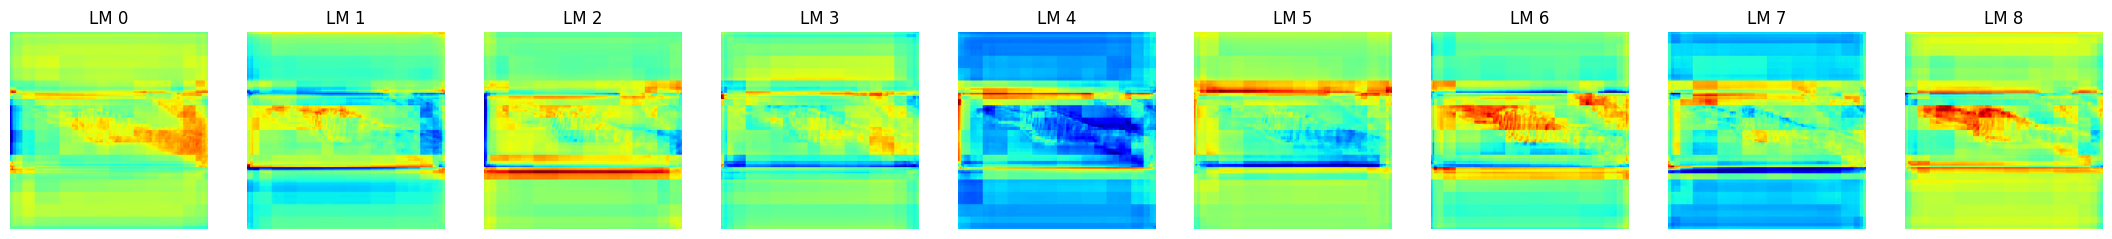

In [219]:
# Inference
test_img = "1016_finger.jpg" # MODIFY

shg.eval()

img = cv2.imread(f"{test_data_dir}/{test_img}")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

padded_img, _ = apply_base_transform(img, None)

img_tensor = torch.from_numpy(padded_img).float() / 255.0
img_tensor = img_tensor.unsqueeze(0)  # [1,3,H,W]
img_tensor = img_tensor.to(device)

with torch.no_grad():
    preds = shg(img_tensor)
    heatmaps = preds[-1]
    hm_batch = heatmaps[0]  # shape: [9,128,128]

    pltbatch = heatmaps[0].cpu().numpy()
    num_landmarks = pltbatch.shape[0]
    
    # plot all heatmaps
    fig, axes = plt.subplots(1, num_landmarks, figsize=(3*num_landmarks,3))
    for i in range(num_landmarks):
        axes[i].imshow(pltbatch[i], cmap='jet')
        axes[i].axis('off')
        axes[i].set_title(f'LM {i}')
    plt.show()

## TESTING

In [174]:
npz = np.load("./data/training_data/heatmaps/1078_0.npz")
heatmap = npz["heatmap"]
print(heatmap.min(), heatmap.max(), heatmap.mean())

0.0 0.9999258 0.0023968406


C:\Users\axu16\AppData\Local\Temp\ipykernel_47664\3646217916.py:4: UserWarning: Argument(s) 'border_value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(512, 512, border_mode=cv2.BORDER_CONSTANT, border_value=0),
C:\Users\axu16\AppData\Local\Temp\ipykernel_47664\3646217916.py:22: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5, 20), p=0.3),


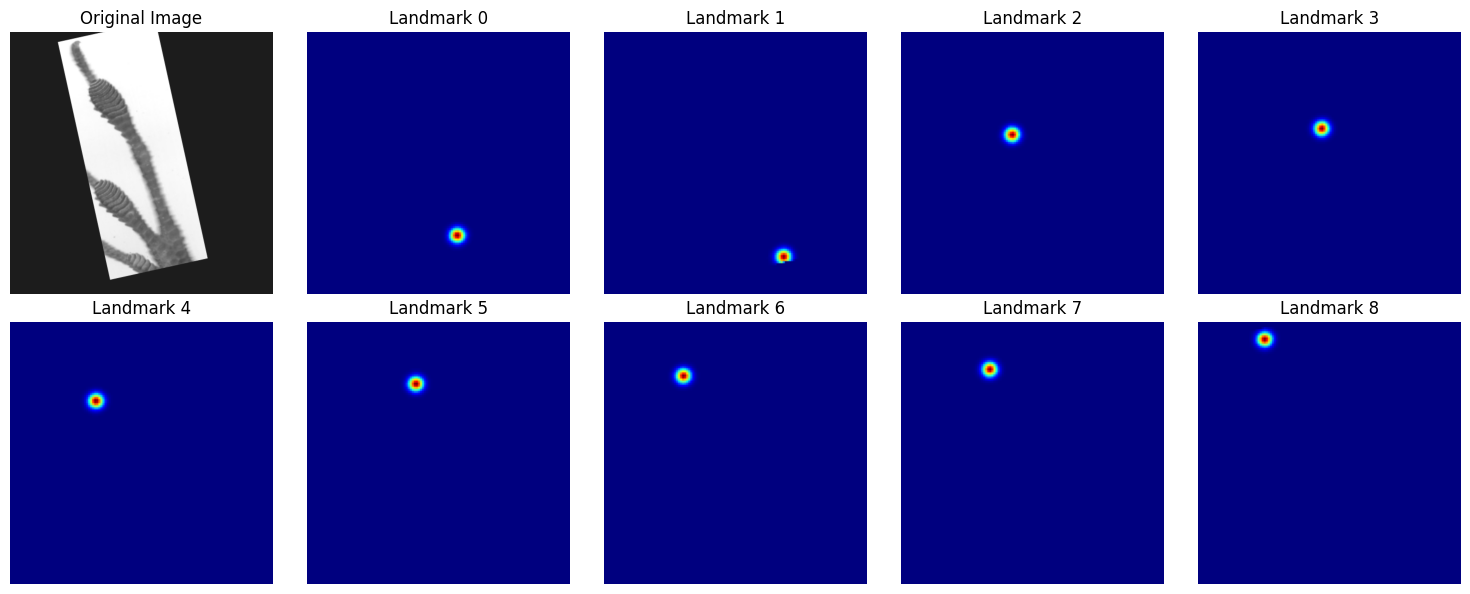

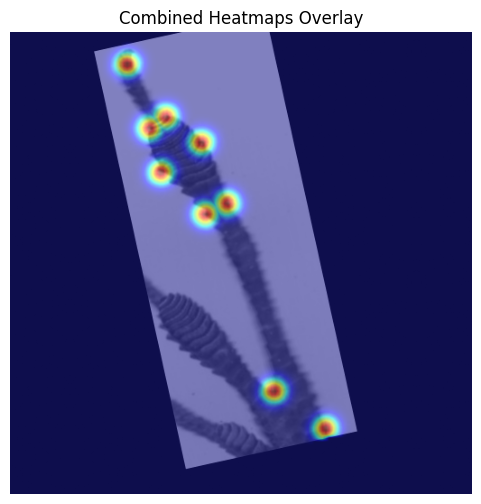

In [207]:
img_tensor, heatmaps_tensor = dataset[0]  # img: [H,C,W], heatmaps: [C,H,W]

# Convert image to [H,W,C] for matplotlib
if img_tensor.shape[1] == 3:  # [H,C,W]
    img = img_tensor.permute(0,2,1).numpy()
else:
    img = img_tensor.numpy()

# Ensure heatmaps_tensor is [C,H,W] and convert to numpy
if heatmaps_tensor.dim() == 4:
    heatmaps_tensor = heatmaps_tensor.squeeze(0)
heatmaps_np = heatmaps_tensor.numpy()  # [C,H,W]

num_landmarks = heatmaps_np.shape[0]

# Normalize each heatmap to 0-1
heatmaps_norm = [(heatmaps_np[i] - heatmaps_np[i].min()) /
                 (heatmaps_np[i].max() - heatmaps_np[i].min() + 1e-8)
                 for i in range(num_landmarks)]

# --------- 1. Grid of individual heatmaps ----------
cols = 5
rows = (num_landmarks + 1 + cols - 1) // cols  # +1 for original image

fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 3*rows))
axes = axes.flatten()

# Original image
axes[0].imshow(img)
axes[0].set_title("Original Image")
axes[0].axis('off')

# Individual heatmaps
for i in range(num_landmarks):
    axes[i+1].imshow(heatmaps_norm[i], cmap='jet')
    axes[i+1].set_title(f"Landmark {i}")
    axes[i+1].axis('off')

# Turn off extra axes
for j in range(num_landmarks+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


# --------- 2. Combined overlay on original image ----------
# Upsample heatmaps to image size
H, W, _ = img.shape
heatmaps_upsampled = [F.interpolate(torch.tensor(hm[None,None,:,:], dtype=torch.float32),
                                    size=(H,W), mode='bilinear', align_corners=False).squeeze().numpy()
                      for hm in heatmaps_norm]

# Combine heatmaps by taking max across landmarks
combined_hm = np.max(np.stack(heatmaps_upsampled, axis=0), axis=0)

plt.figure(figsize=(6,6))
plt.imshow(img)
plt.imshow(combined_hm, cmap='jet', alpha=0.5)
plt.title("Combined Heatmaps Overlay")
plt.axis('off')
plt.show()